# FCT Slowdown Analysis

This notebook analyzes the Flow Completion Time (FCT) slowdown data generated from the network simulation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


In [2]:
# Load the data
data_dir = '/data1/lichenni/m4/testbed/eval_train/0/ns3'

fct_actual = np.load(os.path.join(data_dir, 'fct_topology_flows.npy'))
fct_ideal = np.load(os.path.join(data_dir, 'fct_i_topology_flows.npy'))
fsize = np.load(os.path.join(data_dir, 'fsize.npy'))
fid = np.load(os.path.join(data_dir, 'fid_topology_flows.npy'))

print(f"Loaded {len(fct_actual)} flow records")
print(f"FCT range: {np.min(fct_actual)} - {np.max(fct_actual)} ns")
print(f"Ideal FCT range: {np.min(fct_ideal)} - {np.max(fct_ideal)} ns")


Loaded 2099798 flow records
FCT range: 19078 - 917417 ns
Ideal FCT range: 19078 - 19114 ns


In [3]:
# Calculate slowdown
slowdown = fct_actual / fct_ideal

print("FCT Slowdown Statistics:")
print(f"Mean: {np.mean(slowdown):.3f}x")
print(f"Median: {np.median(slowdown):.3f}x")
print(f"Std: {np.std(slowdown):.3f}x")
print(f"Min: {np.min(slowdown):.3f}x")
print(f"Max: {np.max(slowdown):.3f}x")
print(f"95th percentile: {np.percentile(slowdown, 95):.3f}x")
print(f"99th percentile: {np.percentile(slowdown, 99):.3f}x")
print(f"99.9th percentile: {np.percentile(slowdown, 99.9):.3f}x")


FCT Slowdown Statistics:
Mean: 2.694x
Median: 2.541x
Std: 1.344x
Min: 1.000x
Max: 48.017x
95th percentile: 5.109x
99th percentile: 6.013x
99.9th percentile: 6.713x


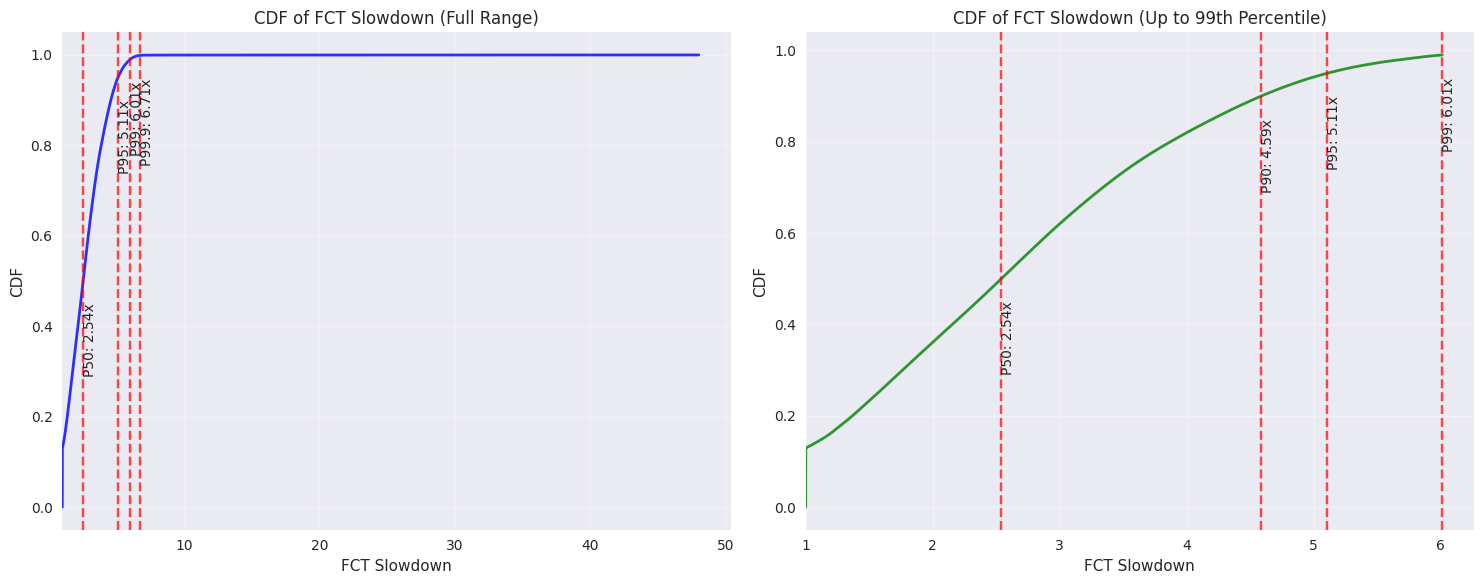

In [4]:
# Plot CDF of FCT Slowdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Full CDF
sorted_slowdown = np.sort(slowdown)
cdf_y = np.arange(1, len(sorted_slowdown) + 1) / len(sorted_slowdown)

ax1.plot(sorted_slowdown, cdf_y, linewidth=2, color='blue', alpha=0.8)
ax1.set_xlabel('FCT Slowdown')
ax1.set_ylabel('CDF')
ax1.set_title('CDF of FCT Slowdown (Full Range)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=1.0)

# Add percentile markers
percentiles = [50, 95, 99, 99.9]
for p in percentiles:
    val = np.percentile(slowdown, p)
    ax1.axvline(val, color='red', linestyle='--', alpha=0.7)
    ax1.text(val, p/100 - 0.05, f'P{p}: {val:.2f}x', 
             rotation=90, verticalalignment='top', fontsize=10)

# Zoomed CDF (focus on main distribution)
mask = slowdown <= np.percentile(slowdown, 99)
sorted_slowdown_zoom = np.sort(slowdown[mask])
cdf_y_zoom = np.arange(1, len(sorted_slowdown_zoom) + 1) / len(slowdown)  # Normalize by total

ax2.plot(sorted_slowdown_zoom, cdf_y_zoom, linewidth=2, color='green', alpha=0.8)
ax2.set_xlabel('FCT Slowdown')
ax2.set_ylabel('CDF')
ax2.set_title('CDF of FCT Slowdown (Up to 99th Percentile)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(left=1.0)

# Add percentile markers for zoomed view
for p in [50, 90, 95, 99]:
    val = np.percentile(slowdown, p)
    if val <= np.percentile(slowdown, 99):
        ax2.axvline(val, color='red', linestyle='--', alpha=0.7)
        ax2.text(val, p/100 - 0.05, f'P{p}: {val:.2f}x', 
                 rotation=90, verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.savefig('/data1/lichenni/m4/testbed/fct_slowdown_cdf.png', dpi=300, bbox_inches='tight')
plt.show()


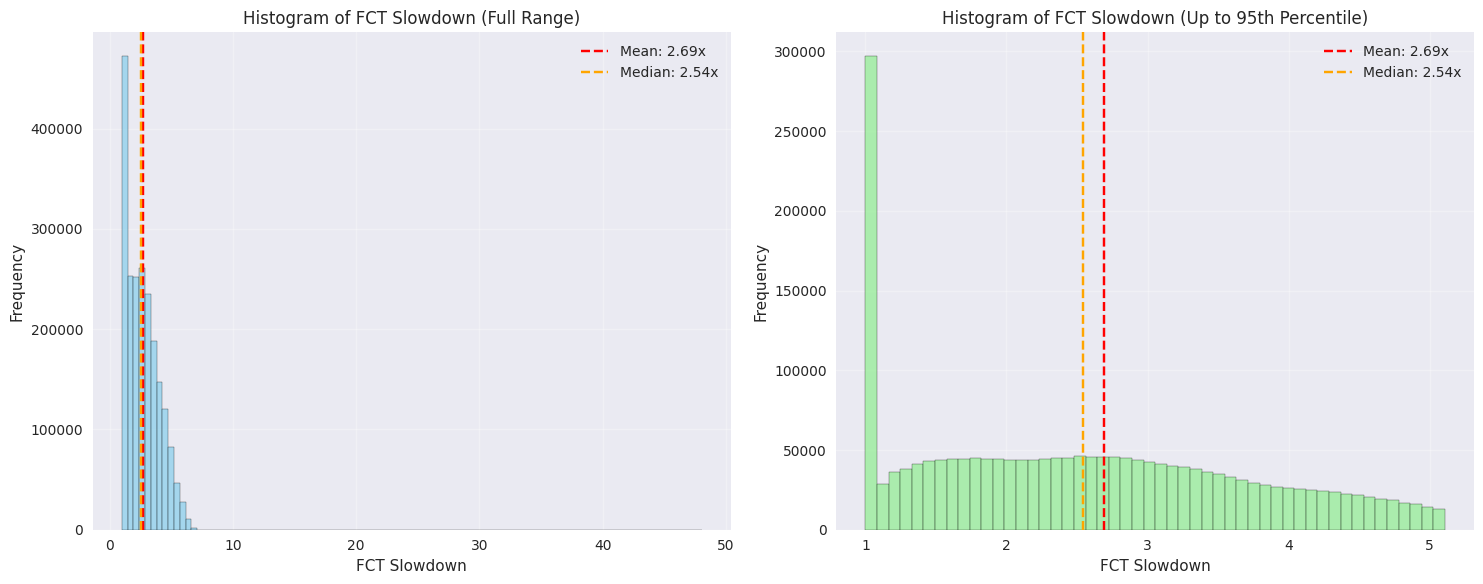

In [5]:
# Additional analysis: Histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Full histogram
ax1.hist(slowdown, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('FCT Slowdown')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of FCT Slowdown (Full Range)')
ax1.grid(True, alpha=0.3)
ax1.axvline(np.mean(slowdown), color='red', linestyle='--', 
            label=f'Mean: {np.mean(slowdown):.2f}x')
ax1.axvline(np.median(slowdown), color='orange', linestyle='--', 
            label=f'Median: {np.median(slowdown):.2f}x')
ax1.legend()

# Zoomed histogram (up to 95th percentile)
mask_95 = slowdown <= np.percentile(slowdown, 95)
ax2.hist(slowdown[mask_95], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_xlabel('FCT Slowdown')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of FCT Slowdown (Up to 95th Percentile)')
ax2.grid(True, alpha=0.3)
ax2.axvline(np.mean(slowdown), color='red', linestyle='--', 
            label=f'Mean: {np.mean(slowdown):.2f}x')
ax2.axvline(np.median(slowdown), color='orange', linestyle='--', 
            label=f'Median: {np.median(slowdown):.2f}x')
ax2.legend()

plt.tight_layout()
plt.savefig('/data1/lichenni/m4/testbed/fct_slowdown_histogram.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# Summary table
print("\n=== SUMMARY REPORT ===")
print(f"Total flows analyzed: {len(slowdown):,}")
print(f"Flow size range: {np.min(fsize[fid])} - {np.max(fsize[fid])} bytes")
print(f"Simulation time: {np.max(np.load(os.path.join(data_dir, 'fat.npy'))) / 1e9:.3f} seconds")
print("\nSlowdown Distribution:")
print(f"  Mean ± Std: {np.mean(slowdown):.3f} ± {np.std(slowdown):.3f}")
print(f"  Median: {np.median(slowdown):.3f}")
print(f"  IQR: {np.percentile(slowdown, 25):.3f} - {np.percentile(slowdown, 75):.3f}")
print(f"  95th percentile: {np.percentile(slowdown, 95):.3f}")
print(f"  99th percentile: {np.percentile(slowdown, 99):.3f}")
print(f"  Max: {np.max(slowdown):.3f}")

# Flows with high slowdown
high_slowdown_threshold = np.percentile(slowdown, 99)
high_slowdown_flows = np.sum(slowdown > high_slowdown_threshold)
print(f"\nFlows with slowdown > {high_slowdown_threshold:.2f}x: {high_slowdown_flows} ({100*high_slowdown_flows/len(slowdown):.1f}%)")

print("\nPlots saved to:")
print("  - /data1/lichenni/m4/testbed/fct_slowdown_cdf.png")
print("  - /data1/lichenni/m4/testbed/fct_slowdown_histogram.png")



=== SUMMARY REPORT ===
Total flows analyzed: 2,099,798
Flow size range: 57 - 103 bytes
Simulation time: 0.532 seconds

Slowdown Distribution:
  Mean ± Std: 2.694 ± 1.344
  Median: 2.541
  IQR: 1.569 - 3.584
  95th percentile: 5.109
  99th percentile: 6.013
  Max: 48.017

Flows with slowdown > 6.01x: 20998 (1.0%)

Plots saved to:
  - /data1/lichenni/m4/testbed/fct_slowdown_cdf.png
  - /data1/lichenni/m4/testbed/fct_slowdown_histogram.png
